# Q Learning TD Parametrized

In [88]:
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Tuple
import copy
import numpy as np
import random, json, csv, os
import matplotlib.pyplot as plt

In [89]:
train = True
save = True
directory_name = 'Q_learning_le_150kepcs_gm_0.6_alp_0.1_epsmin_0.1_TD14'

In [90]:
ACTIONS = [ "none",
            "attack",
            "scolding",
            "intimidate",
            "grudge",
            "sharing_happiness",
            "happy_person",
            "satisfaction",
            "sharing_fear",
            "running_away",
            "sharing_sadness",
            "disappointment",
            "surprise",
            "disbelief",
            "astonishment"
            ]

            
            
EMOTIONS = ["none",
            "fear",
            "joy",
            "surprise",
            "sadness",
            "anger"
            ]

EMOTION_PER_ACTION = { "none": "none",
            "attack" : "anger",
            "scolding": "anger",
            "intimidate": "anger",
            "grudge": "anger",
            "sharing_happiness": "joy",
            "happy_person": "joy",
            "satisfaction": "joy",
            "sharing_fear": "fear",
            "running_away": "fear",
            "sharing_sadness": "sadness",
            "disappointment": "sadness",
            "surprise": "surprise",
            "disbelief": "surprise",
            "astonishment": "surprise"
}

In [91]:
SCENIC_ACTION_SIZE = len(ACTIONS)
EMOTIONAL_REACTION_SIZE = len(EMOTIONS)

MAXIMUM_SKETCH_LENGTH = 15

In [92]:
# returns the code number of an action given by name
def parse_action(action):
    return ACTIONS.index(action)

#returns the action associated to a code
def unparse_action(code):
    return ACTIONS[code]

# returns the code number of an action given by name
def parse_emotion(action):
    return EMOTIONS.index(action)

#returns the action associated to a code
def unparse_emotion(code):
    return EMOTIONS[code]

def convert_action_into_emo(action):
    return EMOTION_PER_ACTION[action]

In [93]:
class ImprobotEnv(Env):

    def __init__(self, actor_space, robot_space, sketch_lenght, env_matrix, P0):

        self.action_space = Discrete(len(robot_space))
        # environment conditions space
        self.observation_space = Tuple((Discrete(len(robot_space)), Discrete(len(actor_space)))) # (robot reaction, actor action)
        self.state = () # (last robot reaction, last actor action)
        self.initial_action_P = P0
        self.sketch_length = sketch_lenght
        self.counter = 0
        self.P = env_matrix # {action: [probability, actor_action, reward]}
        self.q_table = np.zeros([self.observation_space[0].n, self.observation_space[1].n, self.action_space.n])
    
    def render(self):
        print(f"Last actor scenic action: {self.state[1]}")
        print(f"Last robot reaction: {self.state[0]}")

    def step(self, action):
        possible_next_states = self.P[action]
        probabilities = []

        for elem in possible_next_states:
            probabilities.append(elem[0])

        #print(probabilities)
        #print(possible_next_states)
        new_observation_idx = np.random.choice(len(possible_next_states), p=probabilities)
        
        new_observation = possible_next_states[new_observation_idx]
        # update state
        new_reaction = action
        new_actor_action = new_observation[1]
        self.state = tuple([new_reaction, new_actor_action])
        reward = new_observation[2]

        return self.state, reward

    def reset(self):
        actor_action = np.random.choice(SCENIC_ACTION_SIZE,p=self.initial_action_P)
        #print(f"initial action: {actor_action}")
        self.state = (0, actor_action) # (none, none)
        self.counter = 0
        return self.state


In [94]:
# initial action probability distribution
equal_prob = 1/(SCENIC_ACTION_SIZE-1)
P0 = np.zeros(15)
P0[1:] = np.full(14, equal_prob)

# Q-learning

In [95]:
def q_learning_eval(env):
    total_epochs = 0
    total_rewards = 0
    episodes = 100

    for _ in range(episodes):
        state = env.reset()
        epochs, reward = 0, 0
        
        done = False
        
        while not done:
            action = np.argmax(env.q_table[state[0]][state[1]][1:]) + 1 # Exploit learned values
            state, reward = env.step(action)

            total_rewards += reward
            
            env.counter += 1

            if env.counter == env.sketch_length:
                done = True
            else:
                done = False

            epochs += 1

        total_epochs += epochs

    print(f"Results after {episodes} episodes:")
    print(f"Average timesteps per episode: {total_epochs / episodes}")
    print(f"Average rewards per episode: {total_rewards / episodes}")
    return total_rewards / episodes

In [96]:
def q_learning_train(alpha, gamma, epsilon, TD_step, min_q_diff, env):
    # mask in order to non choose action none during the training
    mask = np.ones(env.observation_space[0].n, dtype=np.int8)
    mask[0] = 0

    epochs_number = 150000

    avg_rwd_history = []
    epochs_vect = []

    eps_vect = []

    for i in range(1, epochs_number):
        q_old = copy.deepcopy(env.q_table)
        state = env.reset()

        epochs, reward = 0, 0
        done = False
        
        if env.action_space.n == SCENIC_ACTION_SIZE:
            epsilon = -0.9/15000 * i + 1 if i < 15000 else 0.1
        elif env.action_space.n == EMOTIONAL_REACTION_SIZE:
            epsilon = -0.9/9000 * i + 1 if i < 9000 else 0.1
        else:
            print("error in the epsilon assignment")

        while not done:
            #print(f"q_values at actual observation: {q_table[state[0]][state[1]]}")

            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample(mask=mask) # Explore action space
                #print(f"random action: {action}")
            else:
                #print(f"here the vector to choose: {q_table[state[0]][state[1]][1:]}")
                action = np.argmax(env.q_table[state[0]][state[1]][1:]) + 1 # Exploit learned values
                #print(f"argmax action: {action}")
            initial_action = action
            old_value = env.q_table[state[0]][state[1]][action]
            G = 0
            rewds = []
            gamma_arr = []
            states = []
            for j in range(TD_step + 1):
                if env.counter + (j) < env.sketch_length:
                    next_state, reward = env.step(action)
                    states.append(next_state)
                    rewds.append(reward)
                    gamma_arr.append(gamma**(j))
                    if random.uniform(0, 1) < epsilon:
                        action = env.action_space.sample(mask=mask) # Explore action space
                        #print(f"random action: {action}")
                    else:
                        #print(f"here the vector to choose: {q_table[state[0]][state[1]][1:]}")
                        action = np.argmax(env.q_table[next_state[0]][next_state[1]][1:]) + 1 # Exploit learned values
                        #print(f"argmax action: {action}")
                else:
                    break
                
            if env.counter + (j) < env.sketch_length:
                next_max = np.max(env.q_table[next_state[0]][next_state[1]])
                rewds.append(next_max)
                #print(j)
                gamma_arr.append(gamma**(j+1))
            
            G = np.multiply(rewds,gamma)
            
            new_value = (1 - alpha) * old_value + np.sum(alpha * np.array(G))
            
            env.q_table[state[0]][state[1]][initial_action] = new_value

            state = states[0]
            

            env.counter += 1

            if env.counter == env.sketch_length:
                done = True
            else:
                done = False

            #print(f"Episode: {i}")
            #print(f"Epoch: {epochs}")
            #print(f"actual_state: {env.state}")
            #print(f"action choosen: {action}")
            #print(f"next_state: {next_state}")
            #print(f"q_value updated: {q_table[state[0]][state[1]][action]}")

        if i % 100 == 0:
            print(f"Episode: {i}")
            print(f"action choosen: {action}")
            print(f"next_state: {next_state}")
            print(f"q_value updated: {env.q_table[state[0]][state[1]][action]}")
            avg_rwd_history.append(q_learning_eval(env))
            epochs_vect.append(i)
            eps_vect.append(epsilon)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(epochs_vect, avg_rwd_history)
    ax1.set_xlabel("Epochs Number")
    ax1.set_ylabel("Average Reward")

    ax2.plot(epochs_vect, eps_vect)
    ax2.set_xlabel("Epochs Number")
    ax2.set_ylabel("Epsilon")
    
    if env.action_space.n == SCENIC_ACTION_SIZE:
        plt.savefig('graphs/'+ 'training_aa_' + directory_name + '.png')
    elif env.action_space.n == EMOTIONAL_REACTION_SIZE:
        plt.savefig('graphs/'+ 'training_ae_' + directory_name + '.png')
    
    plt.show()

    '''
        # break the loop if converge
    diff = np.sum(env.q_table - q_old)
    if diff < min_q_diff:
        print("convergence reached")
        break
    '''
    print("Training finished.\n")

In [97]:
def save_q_table(env,table_name, dir_name):
    reshaped_Q = env.q_table.reshape((env.q_table.shape[0]*env.q_table.shape[1]),env.q_table.shape[2])
    header = ["S(robot reaction, actor action)", "none", "attack", "scolding", "intimidate", "grudge", "sharing_happiness",
          "happy_person", "satisfaction", "sharing_fear", "running_away", "sharing_sadness", "disappointment",
          "surprise", "disbelief", "astonishment"] if env.observation_space[0].n == 15 else ["S(robot reaction, actor action)", "none", "fear", "joy", "surprise", "sadness", "anger"]
    reaction_unparser = unparse_action if env.observation_space[0].n == 15 else unparse_emotion
    
    data = []
    
    for i in range(reshaped_Q.shape[0]):
        if int(i/env.observation_space[1].n) == 0:
            reaction = reaction_unparser(0)
            row = [(reaction,unparse_action(i))]
        else:
            reaction = int(i/env.observation_space[1].n)
            #print(f"here is the reaction: {reaction}")
            #print(f"here is the i: {i}")
            reaction = reaction_unparser(reaction)
            row = [(reaction, unparse_action((i%env.observation_space[1].n)))]
        row.extend(reshaped_Q[i])
        data.append(row)

    # Scrittura del file CSV
    if not os.path.exists('trials/' + dir_name):
        os.makedirs('trials/' + dir_name)

    with open('trials/' + dir_name + '/' + table_name + '.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(data)

# Action-per-Action learning Test

### Load P action per action matrix

In [98]:
with open('P_action_per_action.json') as f:
    P_aa = json.load(f)

print(P_aa)

# convert keys into numbers
new_P = {}
for k in P_aa.keys():
    new_P[int(k)]=P_aa[k]

P_aa = new_P
print(P_aa)

{'1': [[0.125, 3, 2], [0.125, 5, 0], [0.125, 6, -4], [0.125, 7, 0], [0.125, 8, 4], [0.25, 10, -1], [0.125, 11, 3]], '2': [[0.14285714285714285, 1, 1], [0.14285714285714285, 2, 4], [0.14285714285714285, 8, 0], [0.2857142857142857, 10, 13], [0.14285714285714285, 11, 4], [0.14285714285714285, 14, 2]], '3': [[0.25, 3, 5], [0.08333333333333333, 4, 0], [0.08333333333333333, 5, 12], [0.16666666666666666, 6, 6], [0.08333333333333333, 7, 0], [0.08333333333333333, 8, 2], [0.25, 10, 9]], '4': [[0.125, 3, 0], [0.125, 8, 1], [0.5, 10, 2], [0.25, 11, 1]], '5': [[0.1, 2, 1], [0.1, 5, 1], [0.2, 6, 8], [0.2, 8, 11], [0.2, 10, 15], [0.1, 11, 2], [0.1, 13, 6]], '6': [[0.08333333333333333, 2, 1], [0.08333333333333333, 3, -2], [0.08333333333333333, 5, 0], [0.3333333333333333, 6, 26], [0.08333333333333333, 8, 0], [0.16666666666666666, 11, -2], [0.08333333333333333, 12, -1], [0.08333333333333333, 14, 3]], '7': [[0.25, 3, 6], [0.125, 7, 0], [0.375, 10, 4], [0.125, 11, 3], [0.125, 12, -1]], '8': [[0.2, 3, 6], 

## Q-Learning off-policy Training

### Create action-per-action environment

In [99]:
env_aa = ImprobotEnv(actor_space=ACTIONS,robot_space=ACTIONS,sketch_lenght=15,env_matrix=P_aa, P0=P0)

Episode: 100
action choosen: 2
next_state: (3, 5)
q_value updated: 0.0
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 54.2
Episode: 200
action choosen: 7
next_state: (4, 3)
q_value updated: 0.0
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 62.73
Episode: 300
action choosen: 1
next_state: (8, 10)
q_value updated: 5.6934
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 65.57
Episode: 400
action choosen: 14
next_state: (7, 12)
q_value updated: 4.599600000000001
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 69.19
Episode: 500
action choosen: 14
next_state: (6, 6)
q_value updated: 12.373113089542525
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 70.44
Episode: 600
action choosen: 10
next_state: (8, 7)
q_value updated: 4.8078
Results after 100 episodes:
Average time

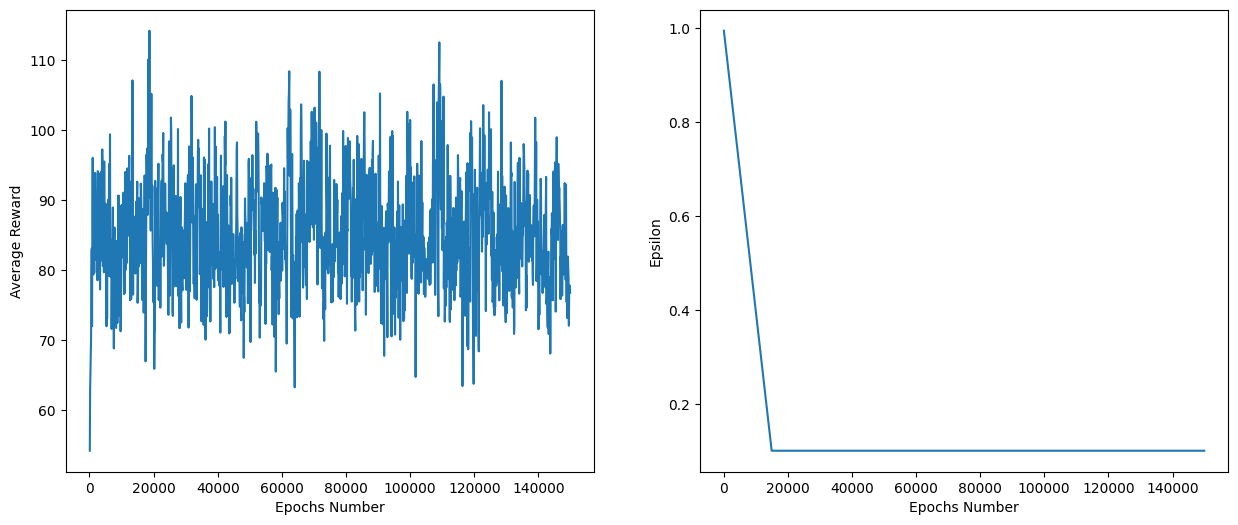

Training finished.



In [100]:

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1
min_difference = 0.000001 # 10^-7
td_step = 14

if train:
    q_learning_train(alpha=alpha,gamma=gamma,epsilon=epsilon, TD_step=td_step,min_q_diff=min_difference,env=env_aa)

## Q-Learning performance evaluation

In [101]:
avg_reward_aa = q_learning_eval(env=env_aa)

Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 83.2


## Q_table visualization

In [102]:
if save:
    save_q_table(env_aa,table_name='q_table_aa', dir_name=directory_name)

### Statistics

In [103]:
q_table = []
with open('trials/' + directory_name + '/' + 'q_table_aa' + '.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        converted_row = [float(element) for element in row[1:]]
        q_table.append(converted_row)

print(q_table)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 55.3976199205611, 55.66844920501091, 55.67370647675223, 52.96413270744384, 55.37911441263736, 55.20028513329452, 55.442234530786145, 54.90268411114196, 53.70398637956894, 53.97715023640311, 54.49092928921179, 55.20764063467896, 55.52138309795894, 55.57915726438862], [0.0, 54.60640095747054, 54.72785212738005, 53.78079112182962, 54.356341192295986, 54.462840646030514, 60.22906841347271, 52.79632848683639, 54.675877516587185, 53.630987827748555, 53.883961156345435, 52.11657483133443, 54.60193015998779, 53.22891689793263, 53.13165483993949], [0.0, 52.926434737860156, 52.47929991208381, 57.057388917274984, 56.59312513509019, 56.975787759376296, 53.9596417957702, 56.76774311824497, 61.742567646926304, 50.68174411118992, 53.29394916656058, 54.492959338128706, 55.07811046135235, 56.61511704856932, 55.712390202557465], [0.0, 54.29057053828334, 57.65318899248851, 56.476866730301325, 55.950971094203666, 57.053854

In [104]:
action = None
count = {}
for a in ACTIONS:
    count[a]=0
for row in q_table:
    #print(row)
    if not max(row) == 0:
        action = row.index(max(row))
        #print(action)
        count[unparse_action(action)] += 1
    #print(count)

print(count)

{'none': 0, 'attack': 3, 'scolding': 11, 'intimidate': 13, 'grudge': 6, 'sharing_happiness': 28, 'happy_person': 14, 'satisfaction': 3, 'sharing_fear': 10, 'running_away': 2, 'sharing_sadness': 4, 'disappointment': 1, 'surprise': 6, 'disbelief': 1, 'astonishment': 2}


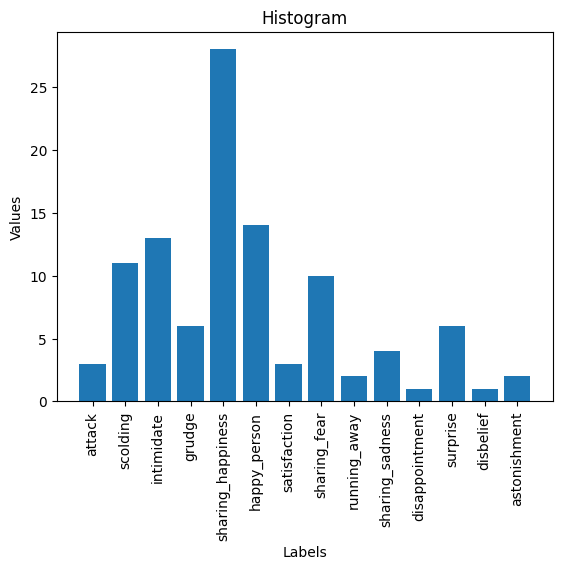

In [105]:
labels = list(count.keys())[1:]
values = list(count.values())[1:]

plt.bar(labels, values)
plt.xlabel('Labels')
plt.ylabel('Values')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.savefig('graphs/'+ 'hist_aa_' + directory_name + '.png')
plt.show()



# Action-per-Emotion Model

### Load P action per emotion matrix

In [106]:
with open('P_action_per_emotion.json') as f:
    P_ae = json.load(f)

print(P_ae)

# convert keys into numbers
new_P = {}
for k in P_ae.keys():
    new_P[int(k)]=P_ae[k]

P_ae = new_P
print(P_ae)

{'1': [[0.15384615384615385, 3, 6], [0.07692307692307693, 5, 4], [0.07692307692307693, 6, 4], [0.07692307692307693, 7, 0], [0.3076923076923077, 8, 7], [0.3076923076923077, 10, 2]], '2': [[0.06666666666666667, 2, 2], [0.1, 3, 4], [0.06666666666666667, 5, 1], [0.2, 6, 34], [0.03333333333333333, 7, 0], [0.1, 8, 11], [0.16666666666666666, 10, 19], [0.13333333333333333, 11, 3], [0.06666666666666667, 12, -2], [0.03333333333333333, 13, 6], [0.03333333333333333, 14, 3]], '3': [[0.019230769230769232, 1, -1], [0.07692307692307693, 2, 6], [0.07692307692307693, 3, 2], [0.038461538461538464, 4, 4], [0.07692307692307693, 5, 1], [0.17307692307692307, 6, 8], [0.07692307692307693, 7, 6], [0.038461538461538464, 8, 3], [0.23076923076923078, 10, 6], [0.11538461538461539, 11, 6], [0.019230769230769232, 12, 4], [0.057692307692307696, 14, 3]], '4': [[0.041666666666666664, 2, 3], [0.08333333333333333, 3, 1], [0.08333333333333333, 4, 0], [0.041666666666666664, 5, -1], [0.16666666666666666, 6, 0], [0.125, 8, -2

### Create action-per-emotion environment

In [107]:
env_ae = ImprobotEnv(actor_space=ACTIONS,robot_space=EMOTIONS,sketch_lenght=15,env_matrix=P_ae, P0=P0)

## Q-Learning off-policy Training

Episode: 100
action choosen: 1
next_state: (3, 2)
q_value updated: 16.19508732
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 136.58
Episode: 200
action choosen: 5
next_state: (3, 3)
q_value updated: 20.985045246000002
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 132.44
Episode: 300
action choosen: 3
next_state: (1, 5)
q_value updated: 17.256068646990602
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 145.94
Episode: 400
action choosen: 2
next_state: (4, 13)
q_value updated: 25.0501115248756
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 121.8
Episode: 500
action choosen: 5
next_state: (5, 10)
q_value updated: 33.13028200918396
Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 142.05
Episode: 600
action choosen: 1
next_state: (1, 8)
q_value updated: 21.837691367

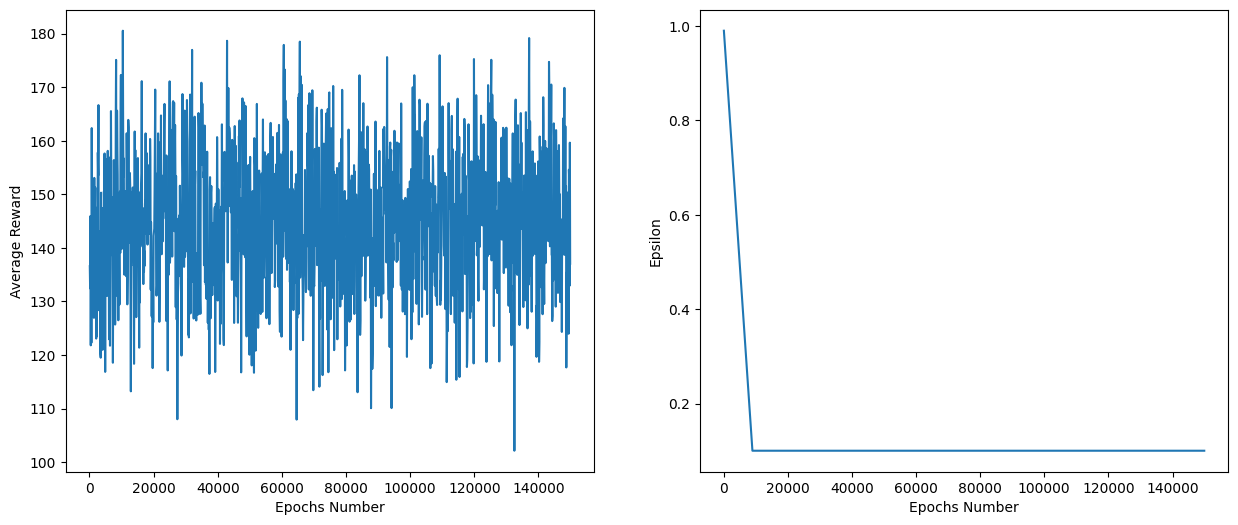

Training finished.



In [108]:
# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1
min_difference = 0.000001
td_step = 14

if train:
    q_learning_train(alpha=alpha,gamma=gamma,epsilon=epsilon, TD_step=td_step,min_q_diff=min_difference,env=env_ae)

## Q-Learning performance evaluation

In [109]:
avg_reward_ae = q_learning_eval(env=env_ae)

Results after 100 episodes:
Average timesteps per episode: 15.0
Average rewards per episode: 125.92


## Q_table visualization

In [110]:
if save:
    save_q_table(env_ae,table_name='q_table_ae', dir_name=directory_name)

In [111]:
#header = ["name", "avg_reward_aa", "avg_reward_ae"]
data = [directory_name, avg_reward_aa, avg_reward_ae]
with open('trials/summary.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    #writer.writerow(header)
    writer.writerow(data)

### Statistics

In [112]:
q_table = []
with open('trials/' + directory_name + '/' + 'q_table_ae' + '.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        converted_row = [float(element) for element in row[1:]]
        q_table.append(converted_row)

print(q_table)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 98.6271337324366, 96.69373751515896, 102.09446991940956, 100.28725895976578, 99.07379935760957], [0.0, 93.9849193095282, 98.33474187855076, 102.36108739695331, 96.75863239949307, 105.17775255211994], [0.0, 100.54658079888485, 98.37410533133982, 97.19364804622722, 97.54940634317259, 110.8694410620121], [0.0, 103.54086127797198, 103.74035013527939, 101.4873117340568, 95.84844234056558, 107.33887199563631], [0.0, 95.28409189679513, 98.28444471011305, 103.38403000221895, 96.2690596909765, 99.65351460904554], [0.0, 99.0591341732668, 105.5315859986243, 98.36116397872675, 99.26308033829922, 99.0839449712233], [0.0, 101.22943719081121, 110.85593104531857, 100.57878533363211, 97.24323784349784, 100.422562393133], [0.0, 96.41388874291485, 105.62687590971, 96.69604796574373, 95.42002640479308, 98.56741959453888], [0.0, 103.36597005403132, 113.81856155217976, 98.73772134870401, 94.70126081025913, 101.31961246033458], [0.0, 103.28882989840636, 102.052504123054

In [113]:
action = None
count = {}
for a in EMOTIONS:
    count[a]=0
for row in q_table:
    #print(row)
    if not max(row) == 0:
        emotion = row.index(max(row))
        #print(action)
        count[unparse_emotion(emotion)] += 1
    #print(count)

print(count)

{'none': 0, 'fear': 3, 'joy': 24, 'surprise': 8, 'sadness': 3, 'anger': 26}


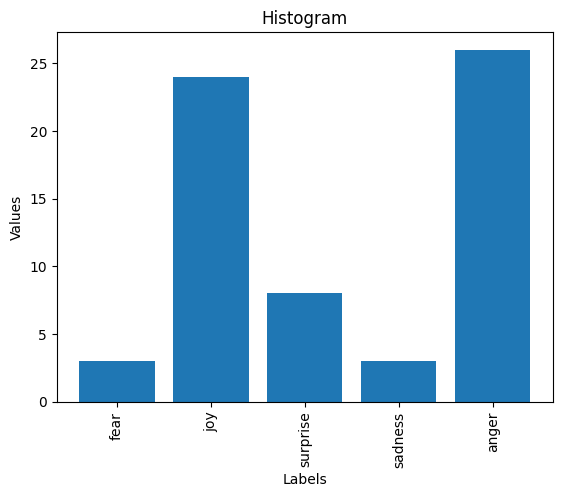

In [114]:
labels = list(count.keys())[1:]
values = list(count.values())[1:]

plt.bar(labels, values)
plt.xlabel('Labels')
plt.ylabel('Values')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.savefig('graphs/'+ 'hist_ae_' + directory_name + '.png')
plt.show()